<img src="./images/paleoCAMPLogo.png"
         width="16%"
         alt="paleoCAMP_logo"
         align="right"
         style="horizontal-align:top;margin:0px 0px"/>

# CESM Output and Analysis


**Tutorial at [the 2024 paleoCAMP](https://paleoclimate.camp/) | June 18–July 1, 2024**  

       
[Jiang Zhu](https://staff.cgd.ucar.edu/jiangzhu/)  
[jiangzhu@ucar.edu](mailto:jiangzhu@ucar.edu)  
Climate & Global Dynamics Laboratory  
NSF National Center for Atmospheric Research  

------

**Learning Objectives:**

* Learn to use the NCAR JupyterHub for data access and analysis
* Learn to read and examine netcdf files using Xarray
* Learn techniques to make basic visualization of temperature, precipitation, and sea-surface temperature
* Learn to assess model-data agreement
* Know how to use and access ESM output

**Time to learn**: 50 minutes

---
**How to get started?**
1. Launch a NCAR JupyterHub server with `Casper PBS Batch`
2. Launch a terminal within JupyterHub 
3. git clone https://github.com/jiang-zhu/paleocamp.git
4. Go back to Jupyter and find and open `3_analyze_CESM_output.ipynb` from the left sidebar

---
Load Python packages

In [1]:
import os
import glob
from datetime import timedelta

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# geocat is used for interpolation the atmosphere output
from geocat.comp import interpolation

# xesmf is used for regridding ocean output
import xesmf

import warnings
warnings.filterwarnings("ignore")

---
## Analysis 1: plot solar insolation in the MH to further validate the simulation

### Load data
- Use `glob` to obtain the file names including path.
- Use wildcard,`*`, to catch all files in the atmosphere history directory (see _Wildcard_ in _0_Prerequisites_1_unix.ipynb_).
- Use `xr.open_mfdataset` to open multiple files at once in parallel (12 month in this case).
- We need to shift the `time` by 15 days to fix a CESM issue.
- We will keep using the Xarray Datasets `ds_MH` and `ds_PI` throughout the Notebook

_Important:_ use your own directory only if you have both piControl and midHolocene simulations finished
- Go to the folder to make sure you have 12 months of model output
  - /glade/derecho/scratch/YOUR_USERNAME/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist
  - /glade/derecho/scratch/YOUR_USERNAME/archive/b.e21.B1850.f19_g17.midHolocene.001/atm/hist
- Use `/glade/derecho/scratch/jiangzhu/archive` if you don't have your own model output

In [2]:
# storage_dir = '/glade/derecho/scratch/YOUR_USERNAME/archive/'

storage_dir = '/glade/derecho/scratch/jiangzhu/archive/'

In [3]:
hist_dir = '/atm/hist/'

case_PI = 'b.e21.B1850.f19_g17.piControl.001'
case_MH = 'b.e21.B1850.f19_g17.midHolocene.001'

files_PI = glob.glob(storage_dir + case_PI + hist_dir + '*.cam.h0.0001*')
files_MH = glob.glob(storage_dir + case_MH + hist_dir + '*.cam.h0.0001*')
print(*files_PI, sep='\n')
print(*files_MH, sep='\n')

/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist/b.e21.B1850.f19_g17.piControl.001.cam.h0.0001-10.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist/b.e21.B1850.f19_g17.piControl.001.cam.h0.0001-02.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist/b.e21.B1850.f19_g17.piControl.001.cam.h0.0001-01.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist/b.e21.B1850.f19_g17.piControl.001.cam.h0.0001-11.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist/b.e21.B1850.f19_g17.piControl.001.cam.h0.0001-06.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist/b.e21.B1850.f19_g17.piControl.001.cam.h0.0001-03.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/atm/hist/b.e21.B1850.f19_g17.piControl.001.cam.h0.0001-05.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19

In [4]:
ds_PI = xr.open_mfdataset(files_PI)
ds_MH = xr.open_mfdataset(files_MH)

# We need this fix to get the correct time, i.e., January to December of year 1
ds_PI['time'] = ds_PI.time.get_index('time') - timedelta(days=15)
ds_MH['time'] = ds_MH.time.get_index('time') - timedelta(days=15)

In [5]:
ds_PI

# Explore the dataset and find the Solar insolation, SOLIN

<xarray.Dataset>
Dimensions:       (lat: 96, zlon: 1, time: 12, nbnd: 2, lon: 144, lev: 26,
                   ilev: 27)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev           (lev) float64 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * ilev          (ilev) float64 2.194 4.895 9.882 18.05 ... 956.0 985.1 1e+03
  * time          (time) object 0001-01-17 00:00:00 ... 0001-12-17 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/122)
    zlon_bnds     (time, zlon, nbnd) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(1, 26), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(1, 26), meta=np.ndarray>
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai          (time, ilev) float64 dask.array<chunksize=(1, 27), meta=np.ndarray>
    ...            ...
    VU            (time, lev, lat, lon) float32 dask.array<chunksize=(1, 26, 96, 144), meta=np.ndarray>
    VV            (time, lev, lat, lon) float32 dask.array<chunksize=(1, 26, 96, 144), meta=np.ndarray>
    Vzm           (time, ilev, lat, zlon) float32 dask.array<chunksize=(1, 27, 96, 1), meta=np.ndarray>
    WTHzm         (time, ilev, lat, zlon) float32 dask.array<chunksize=(1, 27, 96, 1), meta=np.ndarray>
    Wzm           (time, ilev, lat, zlon) float32 dask.array<chunksize=(1, 27, 96, 1), meta=np.ndarray>
    Z3            (time, lev, lat, lon) float32 dask.array<chunksize=(1, 26, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.B1850.f19_g17.piControl.001
    logname:           jiangzhu
    host:              derecho1
    initial_file:      /glade/campaign/cesm/cesmdata/inputdata/atm/cam/inic/f...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

### Compute the zonal mean of solar insolation and make plots
- Use `.mean('lon')` to get the zonal mean
- Use the Xarray plotting functionality directly

In [6]:
ds_PI.SOLIN

<xarray.DataArray 'SOLIN' (time: 12, lat: 96, lon: 144)>
dask.array<concatenate, shape=(12, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0001-01-17 00:00:00 ... 0001-12-17 00:00:00
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Solar insolation
    cell_methods:       time: mean

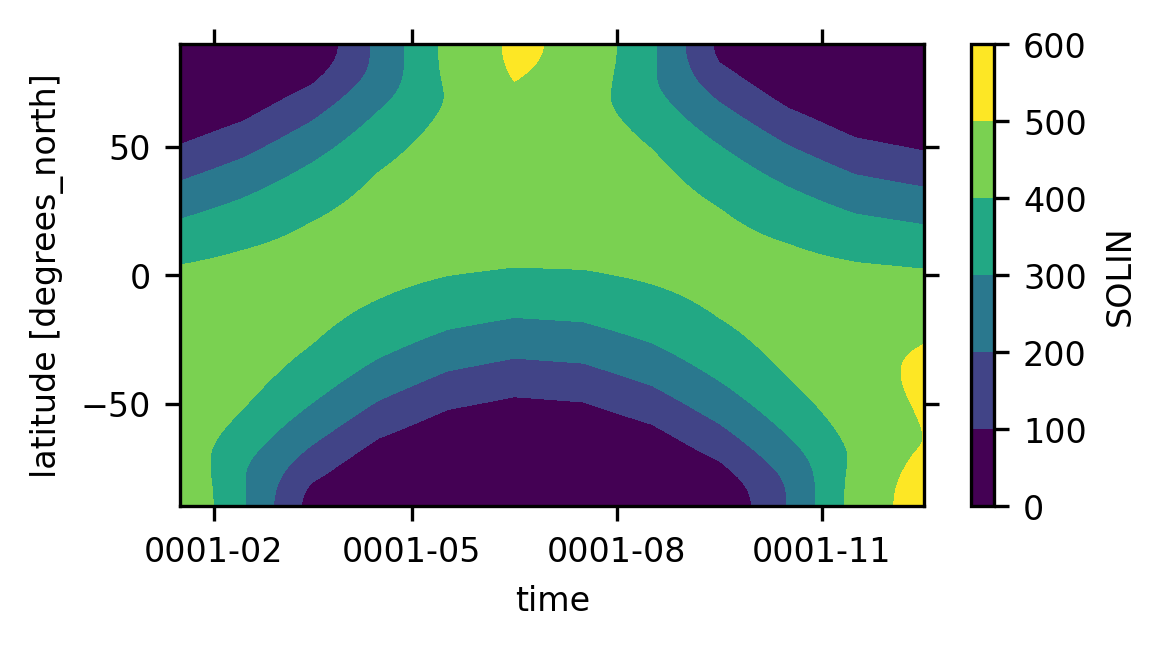

In [7]:
# Compute zonal mean and make plot of piControl
ds_PI.SOLIN.mean('lon').plot.contourf(x='time', y='lat', figsize=(4, 2))

In [8]:
# Add your code to compute zonal mean and make plot of midHolocene


In [9]:
# Add your code to compute and plot the difference: midHolocen - piControl zonal mean


<div class="alert alert-success">   
<details>
 
<summary><font face="Times New Roman" color='blue'>Single-click here for the solution</font></summary><br>
Copy and paste the code into the above cell

```python

ds_MH.SOLIN.mean('lon').plot.contourf(x='time', y='lat', figsize=(4, 2))


(ds_MH.SOLIN - ds_PI.SOLIN).mean('lon').plot.contourf(
    x='time', y='lat', figsize=(4, 2), levels=np.linspace(-30, 30, 21))

```

</details>
</div>

### Small group discussion
- Which orbital parameters are different at the middle Holocene (6ka BP)?
- How does the orbital parameter impact the top-of-atmosphere shortwave radiation (solar insolation)
- Do the results look correct? You can compare your results with Figure 3b of [Otto-Bliesner et al., (2017)](https://gmd.copernicus.org/articles/10/3979/2017/gmd-10-3979-2017.pdf)

---
## Analysis 2: Does the Earth receive more radiation during the midHolocene?
- We compute the global annual mean solar insolation to answer this question.
- ***Importantly,*** we need to weight grid cells by their area (equivalent to cosine of latitude), using the `.weighted` method

Note that lat is in degree

In [10]:
ds_PI.lat

<xarray.DataArray 'lat' (lat: 96)>
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -29.368421, -27.473684, -25.578947, -23.684211,
       -21.789474, -19.894737, -18.      , -16.105263, -14.210526, -12.315789,
       -10.421053,  -8.526316,  -6.631579,  -4.736842,  -2.842105,  -0.947368,
         0.947368,   2.842105,   4.736842,   6.631579,   8.526316,  10.421053,
        12.315789,  14.210526,  16.105263,  18.      ,  19.894737,  21.789474,
        23.684211,  25.578947,  27.473684,  29.368421,  31.263158,  33.157895,
        35.052632,  36.947368,  38.842105,  40.736842,  42.631579,  44.526316,
        46.421053,  48.315789,  50.210526,  52.105263,  54.      ,  55.894737,
        57.789474,  59.684211,  61.578947,  63.473684,  65.368421,  67.263158,
        69.157895,  71.052632,  72.947368,  74.842105,  76.736842,  78.631579,
        80.526316,  82.421053,  84.315789,  86.210526,  88.105263,  90.      ])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    long_name:  latitude
    units:      degrees_north

### Example calculation for the piControl

In [11]:
coslat = np.cos(np.deg2rad(ds_PI.lat))

SOLIN_PI = ds_PI.SOLIN.weighted(coslat).mean(('lat', 'lon', 'time'))
print("The global annual mean insolation of PI: ", SOLIN_PI.values, "W/m2")

The global annual mean insolation of PI:  340.3271967819253 W/m2


### If we don't apply the area weights, we will get a wrong answer

In [12]:
SOLIN_PI_unweighted = ds_PI.SOLIN.mean(('lat', 'lon', 'time'))
print("Only if we forgot to properly weight the values by area:",
      SOLIN_PI_unweighted.values, "W/m2")

Only if we forgot to properly weight the values by area: 297.03168 W/m2


### Add your own calculation for the mid-Holocene

<div class="alert alert-success">   
<details>
 
<summary><font face="Times New Roman" color='blue'>Single click here for the solution</font></summary><br>
Copy and paste the code into the above cell

```python
coslat = np.cos(np.deg2rad(ds_MH.lat))

SOLIN_MH = ds_MH.SOLIN.weighted(coslat).mean(('lat', 'lon', 'time'))
print("The global annual mean insolation of MH: ", SOLIN_MH.values, "W/m2")
print("Difference, MH - PI: ", SOLIN_MH.values-SOLIN_PI.values, "W/m2")

```

</details>
</div>

### Small group discussion
- Which orbital parameters are different at the mid-Holocene (6ka BP)?
- Is the difference in MH SOLIN a big radiative forcing?
- Should the mid-Holocene be warmer or colder than the preindustrial?
  - Geological records suggest that MH may be warmer than the present day
  - Climate models in general suggest a colder mid-Holocene
  - Further reading: [Osman et al. (2021)](https://www-nature-com.cuucar.idm.oclc.org/articles/s41586-021-03984-4)
  - Ask Jess and Jiang about the _Holocene Temperature Conundrum_

---
## Analysis 3: how does the midHolocene orbital forcing impact the ITCZ and monsoon precipitation?
- In CESM, total precipitation is computed as `prec = PRECC + PRECL` (sum of convective and large-scale precipitation; recall that climate models have to parameterize convection!)
- We convert the units from m/s into mm/day
- We use `.isel(time=slice(5, 8))` to select the June, July, and Agugust values (recall that Python uses 0-based ordering)
- Let's use Cartopy and Matplotlib with a Robinson projection (instead of using the simple Xarray.plot)
- We use `add_cyclic_point` to get rid of the "white strip" in the plot

In [13]:
ds_PI.PRECC

<xarray.DataArray 'PRECC' (time: 12, lat: 96, lon: 144)>
dask.array<concatenate, shape=(12, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0001-01-17 00:00:00 ... 0001-12-17 00:00:00
Attributes:
    units:         m/s
    long_name:     Convective precipitation rate (liq + ice)
    cell_methods:  time: mean

In [14]:
m_p_s_to_mm_p_day = 86400000

prec_PI = (ds_PI.PRECC + ds_PI.PRECL).isel(time=slice(5, 8)).mean('time') * m_p_s_to_mm_p_day
prec_PI

<xarray.DataArray (lat: 96, lon: 144)>
dask.array<mul, shape=(96, 144), dtype=float64, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

### Plot total precipitation of piControl

Text(0.5, 1.0, 'PI precipitation')

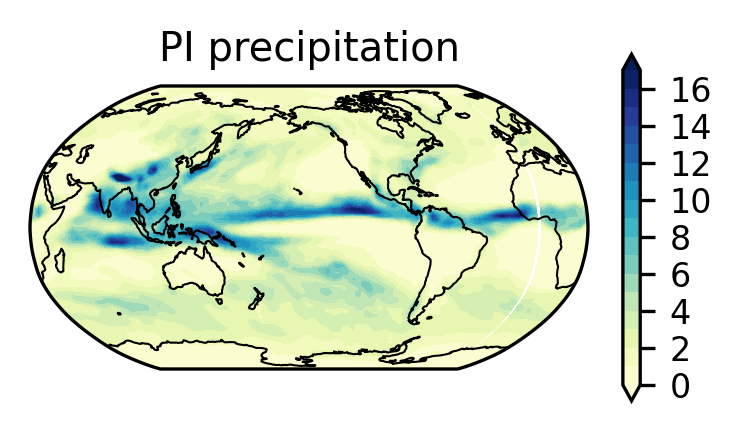

In [15]:
fig, ax = plt.subplots(figsize=(3, 1.5), subplot_kw={
    'projection': ccrs.Robinson(central_longitude=210)})

p1 = ax.contourf(prec_PI.lon, prec_PI.lat, prec_PI,
                 cmap='YlGnBu',
                 levels=np.linspace(0, 17, 18),
                 extend='both',
                 transform=ccrs.PlateCarree())

ax.coastlines(linewidth=0.5)
plt.colorbar(p1)
ax.set_title("PI precipitation")

### Let's use `add_cyclic_point` to get rid of the "white strip" in the plot

Text(0.5, 1.0, 'PI precipitation')

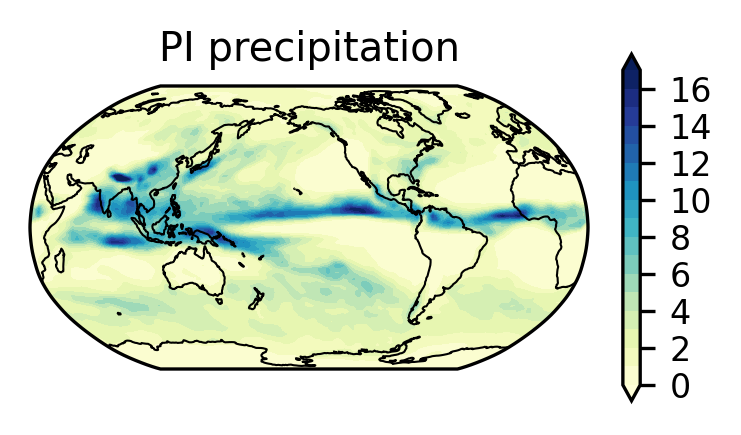

In [16]:
fig, ax = plt.subplots(figsize=(3, 1.5), subplot_kw={
    'projection': ccrs.Robinson(central_longitude=210)})

# Note the differences in the next two lines
prec_PI_new, lon_new = add_cyclic_point(prec_PI, prec_PI.lon)
p1 = ax.contourf(lon_new, prec_PI.lat, prec_PI_new,
                 cmap='YlGnBu',
                 levels=np.linspace(0, 17, 18),
                 extend='both',
                 transform=ccrs.PlateCarree())

ax.coastlines(linewidth=0.5)
plt.colorbar(p1)
ax.set_title("PI precipitation")

### Add your own plot of the midHolocene precipitatin

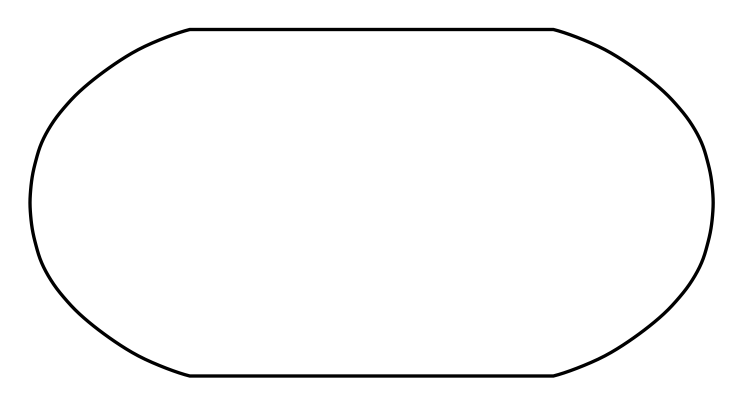

In [17]:
fig, ax = plt.subplots(figsize=(3, 1.5), subplot_kw={
    'projection': ccrs.Robinson(central_longitude=210)})



### Add your own plot of the midHolocene - piControl

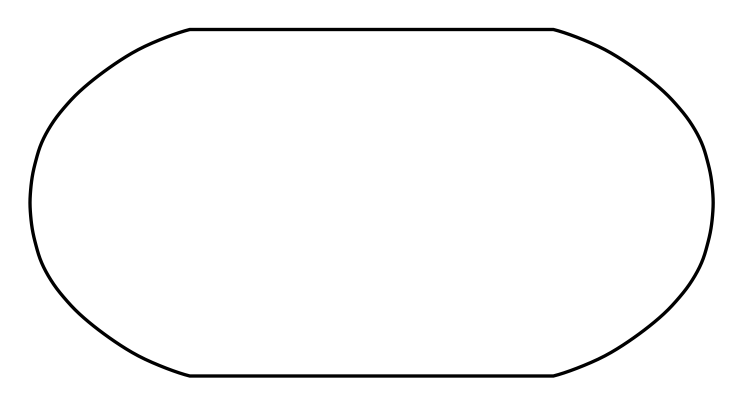

In [18]:
fig, ax = plt.subplots(figsize=(3, 1.5), subplot_kw={
    'projection': ccrs.Robinson(central_longitude=210)})



### Discussion
- Do you see the ITCZ shift during the mid-Holocene?
- Do you see changes of the monsoon precipitation?
- Ask Kathleen, Tripti, and Kevin about ITCZ and monsoon!

---
## Analysis 4: how does the MH orbital forcing impact the atmospheric circulation?
- We plot the zonal mean zonal wind of PI in the Northern Hemisphere summer (JJA)
- We use `plt.gca().invert_yaxis()` to invert the y-axis such that the high pressure is at the bottom

In [19]:
ds_PI.U

<xarray.DataArray 'U' (time: 12, lev: 26, lat: 96, lon: 144)>
dask.array<concatenate, shape=(12, 26, 96, 144), dtype=float32, chunksize=(1, 26, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-01-17 00:00:00 ... 0001-12-17 00:00:00
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean

### Plot the zonal mean of u-winds of JJA

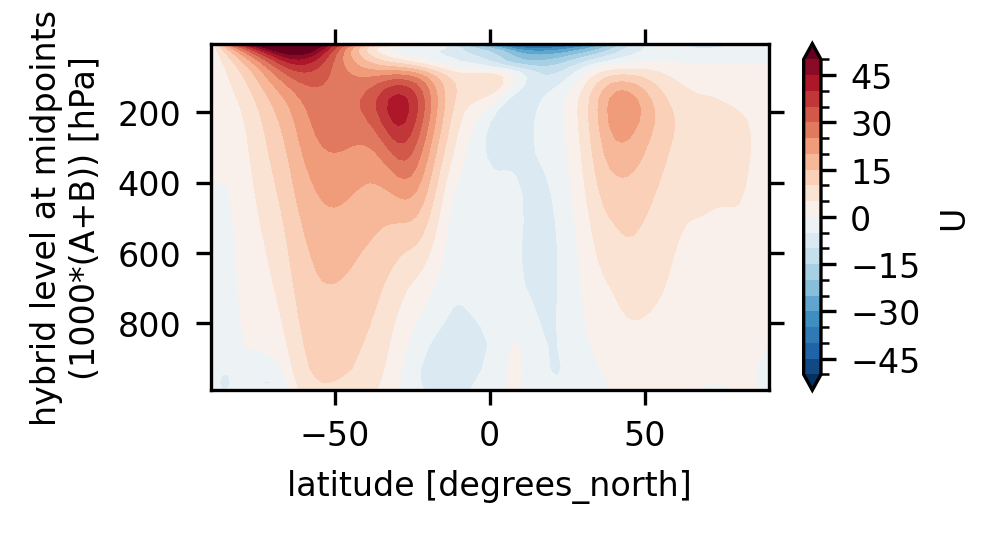

In [20]:
U_PI_za_jja = ds_PI.U.isel(time=slice(5, 8)).mean(('lon', 'time'))

U_PI_za_jja.plot.contourf(figsize=(3, 1.5),
                          levels=np.linspace(-50, 50, 21), extend='both', )
plt.gca().invert_yaxis()

### Add your own plot to show the changes during the midHolocene

<div class="alert alert-success">   
<details>
 
<summary><font face="Times New Roman" color='blue'>Signle click here for the solution</font></summary><br>
Copy and paste the code into the above cell

```python
dU_MH_za_jja = (ds_MH.U - ds_PI.U).isel(time=slice(5, 8)).mean(('lon', 'time'))

dU_MH_za_jja.plot.contourf(figsize=(3, 1.5),
                          levels=np.linspace(-10, 10, 21), extend='both', )
plt.gca().invert_yaxis()
```

</details>
</div>

### Did you notice any problem with the above plots? 
- Check out the name of the vertical levels. it is called [hybrid sigma-pressure coordinate](https://www2.cesm.ucar.edu/models/atm-cam/docs/usersguide/node25.html), which is ***NOT*** the pressure coordinate.
- We need to interpolate from the hybrid sigma-pressure coordinate into the normal pressure coordinate

In [21]:
ds_PI.lev.standard_name

'atmosphere_hybrid_sigma_pressure_coordinate'

### Use geocat interpolation to interpolate from hybrid sigma-pressure to presure coordinate

In [22]:
P_new_mb = np.array([1, 10, 20, 50., 100., 200., 300.,
                    400., 500., 600., 700., 800., 900., 1000.])
p0_mb = 1000.

Up_PI = interpolation.interp_hybrid_to_pressure(
    ds_PI.U,
    ds_PI.PS,
    ds_PI.hyam,
    ds_PI.hybm,
    p0=p0_mb*100.,
    new_levels=P_new_mb*100.,
    extrapolate=False)

Up_MH = interpolation.interp_hybrid_to_pressure(
    ds_MH.U,
    ds_MH.PS,
    ds_MH.hyam,
    ds_MH.hybm,
    p0=p0_mb*100.,
    new_levels=P_new_mb*100.,
    extrapolate=False)

### Plot the correct results!

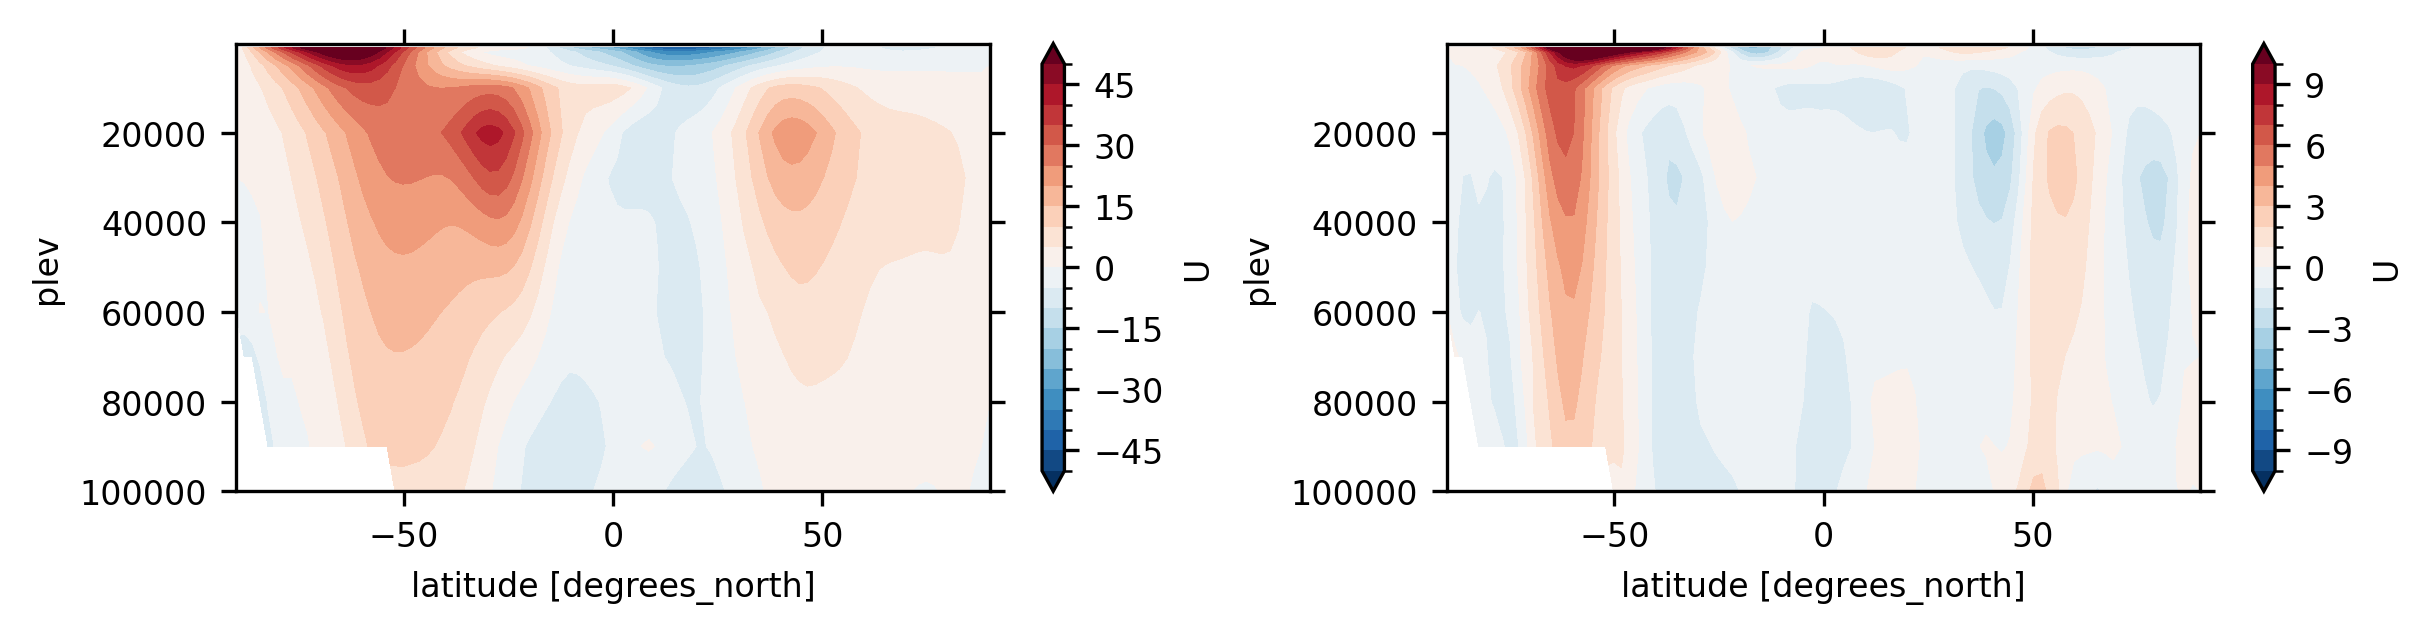

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(8, 2),
                         constrained_layout=True)

Up_PI.isel(time=slice(5, 8)).mean(('lon', 'time')).plot.contourf(
    ax=axes[0], levels=np.linspace(-50, 50, 21), extend='both')

(Up_MH - Up_PI).isel(time=slice(5, 8)).mean(('lon', 'time')).plot.contourf(
    ax=axes[1], levels=np.linspace(-10, 10, 21), extend='both')

for ax in axes:
    ax.invert_yaxis()

### Small group discussion
- Which hemisphere has a stronger jet stream? Why? (remember that the plots are for JJA, the NH summer)
- Does the mid-Holocene orbital forcing shift the jet stream?
- Ask Tripti and Kevin about the atmosphere circulation! 

---
## Analysis 5: how about sea-surface temperature?
- Ocean data is in `ocn/hist`
- SST is the top level of TEMP

In [24]:
hist_dir = '/ocn/hist/'

case_PI = 'b.e21.B1850.f19_g17.piControl.001'
case_MH = 'b.e21.B1850.f19_g17.midHolocene.001'

files_PI_ocn = glob.glob(storage_dir + case_PI + hist_dir + '*.pop.h.0001*')
files_MH_ocn = glob.glob(storage_dir + case_MH + hist_dir + '*.pop.h.0001*')
print(*files_PI_ocn, sep='\n')
print(*files_MH_ocn, sep='\n')

ds_PI_ocn = xr.open_mfdataset(files_PI_ocn)
ds_MH_ocn = xr.open_mfdataset(files_MH_ocn)

# Again, we need this fix to get the correct time, i.e., month 1 to month 12
ds_PI_ocn['time'] = ds_PI_ocn.time.get_index('time') - timedelta(days=15)
ds_MH_ocn['time'] = ds_MH_ocn.time.get_index('time') - timedelta(days=15)

/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/ocn/hist/b.e21.B1850.f19_g17.piControl.001.pop.h.0001-03.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/ocn/hist/b.e21.B1850.f19_g17.piControl.001.pop.h.0001-01.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/ocn/hist/b.e21.B1850.f19_g17.piControl.001.pop.h.0001-02.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/ocn/hist/b.e21.B1850.f19_g17.piControl.001.pop.h.0001-09.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/ocn/hist/b.e21.B1850.f19_g17.piControl.001.pop.h.0001-10.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/ocn/hist/b.e21.B1850.f19_g17.piControl.001.pop.h.0001-08.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.piControl.001/ocn/hist/b.e21.B1850.f19_g17.piControl.001.pop.h.0001-11.nc
/glade/derecho/scratch/jiangzhu/archive/b.e21.B1850.f19_g17.pi

In [25]:
ds_PI_ocn

<xarray.Dataset>
Dimensions:                 (time: 12, d2: 2, moc_comp: 3, transport_comp: 5,
                             transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60,
                             z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395,
                             moc_z: 61, nlat: 384, nlon: 320)
Coordinates: (12/15)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
  * time                    (time) object 0001-01-17 00:00:00 ... 0001-12-17 ...
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
    ...                      ...
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, moc_comp, transport_comp, transport_reg,
                                nlat, nlon
Data variables: (12/171)
    time_bound              (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    dz                      (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    dzw                     (time, z_w) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    KMT                     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMU                     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    REGION_MASK             (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ...                      ...
    XBLT                    (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TBLT                    (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    BSF                     (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    MOC                     (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 3, 61, 395), meta=np.ndarray>
    N_HEAT                  (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
    N_SALT                  (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f19_g17.piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-06-08 at 11:04:11.5
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Calculate annual mean SST and make a simple plot using Xarray

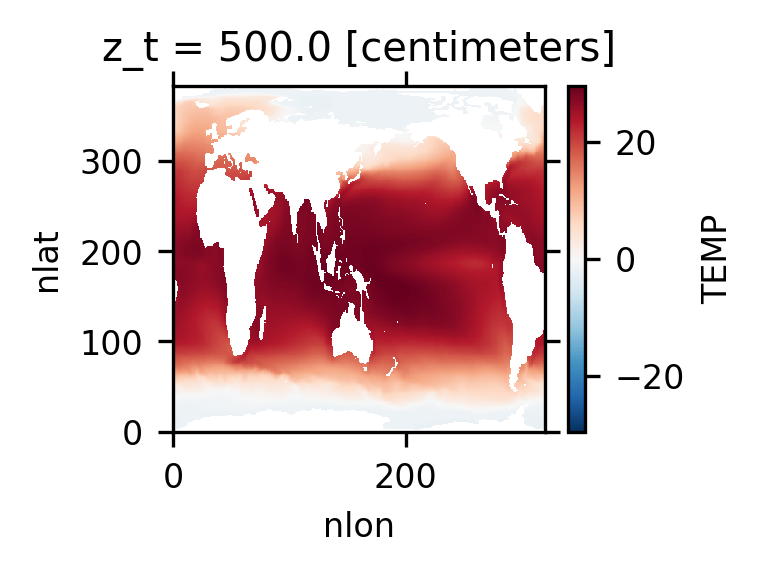

In [26]:
sst_PI = ds_PI_ocn.TEMP.isel(z_t=0).mean('time')
sst_MH = ds_MH_ocn.TEMP.isel(z_t=0).mean('time')

sst_PI.plot(size=1.5)

- What do nlat and nlon mean?
- Where is Greenland? It is the "north pole" in the model!
  
<img src="./images/pop_gx1_grid.png"
         width="20%"
         style="horizontal-align:top;margin:10px 0px"/>

### Regridding is needed!

In [27]:
%%time

ds_PI_ocn['lat'] = ds_PI_ocn.TLAT
ds_PI_ocn['lon'] = ds_PI_ocn.TLONG

regridder = xesmf.Regridder(
    ds_in=ds_PI_ocn,
    ds_out=xesmf.util.grid_global(1, 1, cf=True, lon1=360),
    method='bilinear',
    periodic=True)

sst_PI_1x1 = regridder(sst_PI)
sst_MH_1x1 = regridder(sst_MH)
sst_PI_1x1

CPU times: user 7.06 s, sys: 401 ms, total: 7.46 s
Wall time: 7.89 s


<xarray.DataArray (lat: 180, lon: 360)>
dask.array<astype, shape=(180, 360), dtype=float32, chunksize=(180, 320), chunktype=numpy.ndarray>
Coordinates:
    z_t                 float32 500.0
  * lon                 (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    latitude_longitude  float64 nan
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

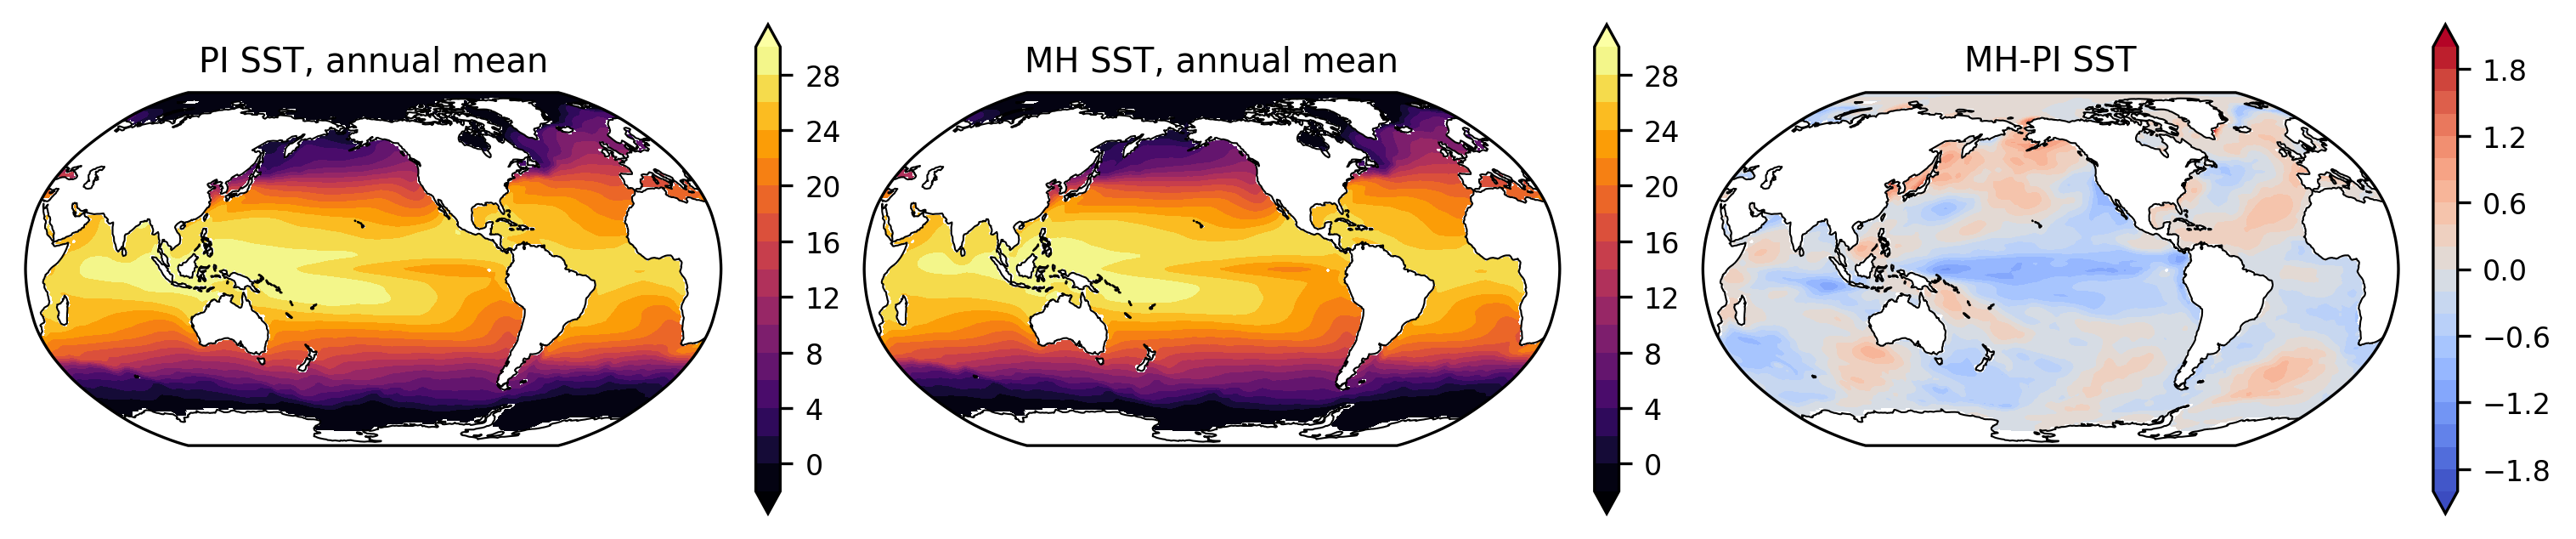

In [28]:
lat = sst_PI_1x1.lat
lon = sst_PI_1x1.lon

fig, axes = plt.subplots(nrows=1, ncols=3,
                         figsize=(10, 2),
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=210)},
                         constrained_layout=True)

ax = axes[0]
ax.set_title("PI SST, annual mean")
sst_PI_new, lon_new = add_cyclic_point(sst_PI_1x1, lon)
p0 = ax.contourf(lon_new, lat, sst_PI_new,
                 levels=np.linspace(-2, 30, 17),
                 cmap='inferno', extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p0, ax=ax)

ax = axes[1]
ax.set_title("MH SST, annual mean")
sst_MH_new, lon_new = add_cyclic_point(sst_MH_1x1, lon)
p1 = ax.contourf(lon_new, lat, sst_MH_new,
                 levels=np.linspace(-2, 30, 17),
                 cmap='inferno', extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p1, ax=ax)

ax = axes[2]
ax.set_title("MH-PI SST")
p2 = ax.contourf(lon_new, lat, sst_MH_new - sst_PI_new,
                 cmap='coolwarm',
                 levels=np.linspace(-2, 2, 21),
                 extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p2, ax=ax)

for ax in axes:
    ax.set_global()
    ax.coastlines(linewidth=0.5)

# We could use savefig to save the plot as pdf
# plt.savefig('SST_xy.PI_vs_MH.pdf', format='pdf', bbox_inches="tight")

### Small group discussion
- Colder SSTs over lots of the regions?
- We need to test significance
- Internal variability?
- What's the timescale of upper ocean response?

---
## Summary so far
- Load multiple CESM output using `Xarray`
- Plot variables in zonal mean and map view
- Interpolate the atmosphere vertical coordinate from hybrid to pressure is needed!
- Ocean models usually use irregular grid with poles moved into land; regridding is needed!
- Mid-Holocene orbital forcing is seasonal and impacts atmosphere circulation, precipitation, and other climate states.